In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torchmetrics
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

### Training a Neural Network:

1. ~~Create a model~~
2. Choose a loss function
3. Create a dataset
4. Define an optimizer
5. Run a training loop, where for each sample of the dataset, we repeat: (akin to .fit in sklearn)
    - Calculating loss (forward pass)
    - Calculating local gradients (backward pass)
    - Updating model parameters

In [91]:
### DATA PROCESSING

# np_array = np.array(array)
# np_tensor = torch.from_numpy(np_array)

data_pd = pd.read_csv('~/Documents/Data Science/programs/iris_neural_net/iris_data.csv')

x = data_pd.drop(['species'], axis=1)
y = data_pd.species

encoder = LabelEncoder()
y = encoder.fit_transform(y)

scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 888)

train_features = torch.from_numpy(x_train)
train_labels = F.one_hot(torch.from_numpy(y_train))

val_features = torch.from_numpy(x_test)
val_labels = F.one_hot(torch.from_numpy(y_test))

In [134]:
### MODEL SETUP

num_epochs = 500
batch_size = 4
learning_rate = 0.001
momentum = 0.95

# CrossEntropyLoss for classification, MSELoss for regression
criterion = CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=3)

train_dataset = TensorDataset(train_features.float(), train_labels.float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_features.float(), val_labels.float())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

def model_run(model, optimizer):
    eps = np.arange(1, num_epochs+1)
    g_train_loss = []
    g_val_loss = []
    model_accuracy = []
    
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        epoch_loss_train = 0.0
        epoch_loss_val = 0.0

        for i, data in enumerate(train_loader, 0):
            optimizer.zero_grad()
            features, target = data
            pred = model(features)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        epoch_loss_train = train_loss / len(train_loader)
        g_train_loss.append(epoch_loss_train)

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                features, target = data
                pred = model(features)
                loss = criterion(pred, target)
                val_loss += loss.item()
                acc = metric(pred, target.argmax(dim=-1)) 
        epoch_loss_val = val_loss / len(val_loader)
        g_val_loss.append(epoch_loss_val)
        # print(f'Epoch loss: {epoch_loss}')
        acc = metric.compute()
        model_accuracy.append(acc.item())
        # print(f'Accuracy on all data: {acc}')
        metric.reset()
        model.train()
    return eps, g_train_loss, g_val_loss, model_accuracy

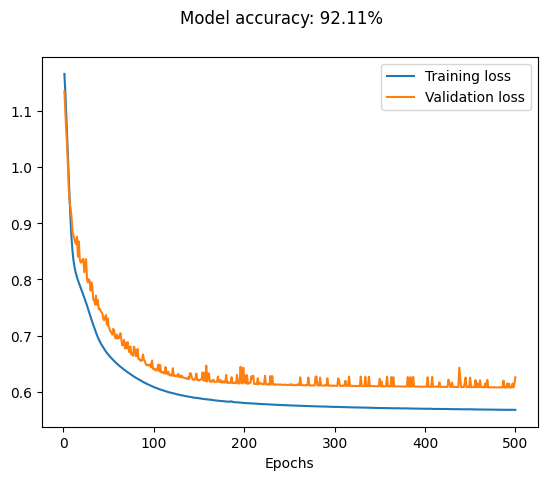

0.9210526347160339


In [135]:
### Basic run

model_init = nn.Sequential(
    nn.Linear(4, 6),
    nn.Linear(6, 3),
    nn.Softmax(dim=-1)
)

optimizer_init = optim.SGD(model_init.parameters(), lr=learning_rate, momentum=momentum)

eps, g_train_loss, g_val_loss, model_accuracy = model_run(model_init, optimizer_init)

fig, ax = plt.subplots()
ax.plot(eps, g_train_loss, label='Training loss')
ax.plot(eps, g_val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.suptitle(f'Model accuracy: {round(max(model_accuracy), 4)*100}%')
plt.legend(loc="upper right")
plt.show()

print(max(model_accuracy))

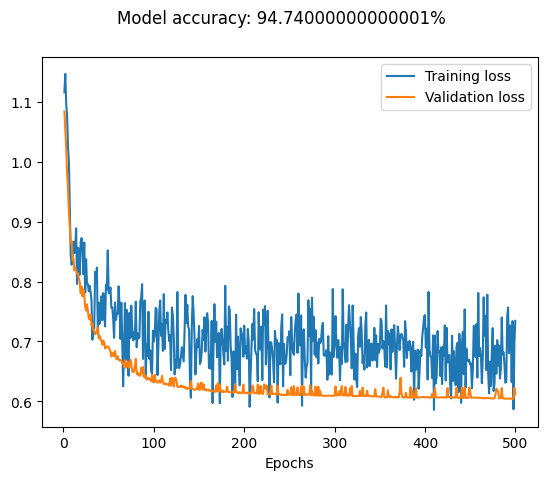

0.9473684430122375


In [136]:
### With dropout

model_drop = nn.Sequential(
    nn.Linear(4, 6),
    nn.Linear(6, 3),
    nn.Softmax(dim=-1),
    nn.Dropout(p=0.5)
)

optimizer_drop = optim.SGD(model_drop.parameters(), lr=learning_rate, momentum=momentum)

eps, g_train_loss, g_val_loss, model_accuracy = model_run(model_drop, optimizer_drop)

fig, ax = plt.subplots()
ax.plot(eps, g_train_loss, label='Training loss')
ax.plot(eps, g_val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.suptitle(f'Model accuracy: {round(max(model_accuracy), 4)*100}%')
plt.legend(loc="upper right")
plt.show()

print(max(model_accuracy))

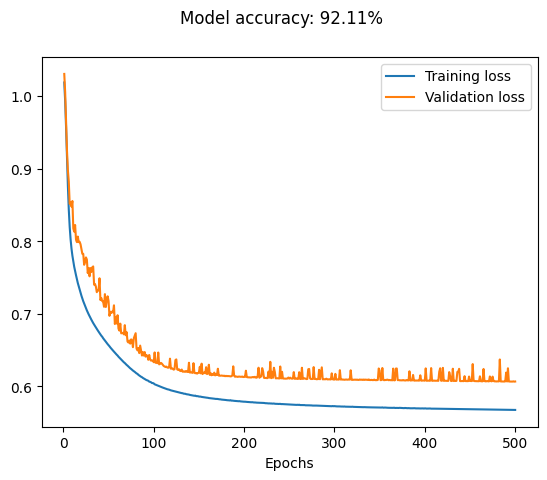

0.9210526347160339


In [137]:
### Weight Decay

model_decay = nn.Sequential(
    nn.Linear(4, 6),
    nn.Linear(6, 3),
    nn.Softmax(dim=-1),
    # nn.Dropout(p=0.5)
)

optimizer_decay = optim.SGD(model_decay.parameters(), lr=learning_rate, momentum=momentum, weight_decay=1e-4)

eps, g_train_loss, g_val_loss, model_accuracy = model_run(model_decay, optimizer_decay)

fig, ax = plt.subplots()
ax.plot(eps, g_train_loss, label='Training loss')
ax.plot(eps, g_val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.suptitle(f'Model accuracy: {round(max(model_accuracy), 4)*100}%')
plt.legend(loc="upper right")
plt.show()

print(max(model_accuracy))

In [ ]:
### Weight Decay + Dropout

model_reg = nn.Sequential(
    nn.Linear(4, 6),
    nn.Linear(6, 3),
    nn.Softmax(dim=-1),
    nn.Dropout(p=0.5)
)

optimizer_reg = optim.SGD(model_reg.parameters(), lr=learning_rate, momentum=momentum, weight_decay=1e-4)

eps, g_train_loss, g_val_loss, model_accuracy = model_run(model_reg, optimizer_reg)

fig, ax = plt.subplots()
ax.plot(eps, g_train_loss, label='Training loss')
ax.plot(eps, g_val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.suptitle(f'Model accuracy: {round(max(model_accuracy), 4)*100}%')
plt.legend(loc="upper right")
plt.show()

print(max(model_accuracy))